'second_final_data_proceed.csv' 파일 (총 1160행)을 성공적으로 불러왔습니다.

총 1160개의 데이터로 모델링을 시작합니다.
훈련 데이터: 928개 / 테스트 데이터: 232개

--- 1. 로지스틱 회귀 모델 학습 중... ---
학습 완료.

--- 2. 모델 평가 (테스트 데이터) ---
모델 정확도(Accuracy): 63.79%
                precision    recall  f1-score   support

No Tsunami (0)       0.79      0.62      0.69       154
   Tsunami (1)       0.47      0.68      0.56        78

      accuracy                           0.64       232
     macro avg       0.63      0.65      0.63       232
  weighted avg       0.68      0.64      0.65       232

혼동 행렬을 'confusion_matrix.png' 파일로 저장했습니다.

--- 3. 훈련된 모델과 스케일러 저장 중... ---
모델을 'scaled_data_tsunami_model.joblib' 파일로 저장했습니다.
스케일러를 'scaled_data_tsunami_scaler.joblib' 파일로 저장했습니다.


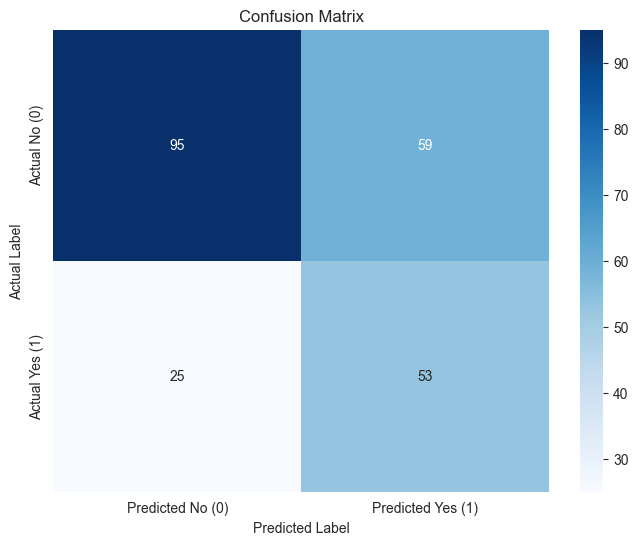

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import joblib # ★★★ 모델 저장을 위해 import

# --- 0. 데이터 불러오기 ---
file_name = 'second_final_data_proceed.csv'
try:
    df = pd.read_csv(file_name)
except FileNotFoundError:
    print(f"오류: '{file_name}' 파일을 찾을 수 없습니다.")
    exit()

print(f"'{file_name}' 파일 (총 {len(df)}행)을 성공적으로 불러왔습니다.")

# --- 1. 전처리 ---
if 'is_ocean' in df.columns:
    df['is_ocean'] = df['is_ocean'].apply(lambda x: 1 if (x == True or str(x).lower() == 'true') else 0)
if 'is_steep_slope' in df.columns:
    df['is_steep_slope'] = df['is_steep_slope'].apply(lambda x: 1 if (x == True or str(x).lower() == 'true') else 0)

# --- 2. 특성(X)과 타겟(y) 정의 ---
# 우리가 최종적으로 만든 6개의 핵심 변수를 사용합니다.
feature_names = [
    'magnitude',
    'depth',
    'is_ocean',
    'is_steep_slope',
    'horizontal_count_1y_full',
    'vertical_count_1y_full'
]
df_model = df[feature_names + ['tsunami']].dropna()
X = df_model[feature_names]
y = df_model['tsunami']

print(f"\n총 {len(df_model)}개의 데이터로 모델링을 시작합니다.")

# --- 3. 훈련 / 테스트 데이터 분리 ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,    # 20%를 테스트용으로 사용
    random_state=42,  # 결과를 재현할 수 있도록 고정
    stratify=y        # 쓰나미 비율(0/1)을 유지
)
print(f"훈련 데이터: {len(X_train)}개 / 테스트 데이터: {len(X_test)}개")

# --- 4. 데이터 스케일링 ---
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# --- 5. 로지스틱 회귀 모델 학습 ---
print("\n--- 1. 로지스틱 회귀 모델 학습 중... ---")
model = LogisticRegression(random_state=42, class_weight='balanced')
model.fit(X_train_scaled, y_train)
print("학습 완료.")

# --- 6. 모델 평가 ---
print("\n--- 2. 모델 평가 (테스트 데이터) ---")
y_pred = model.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)
print(f"모델 정확도(Accuracy): {accuracy * 100:.2f}%")
print(classification_report(y_test, y_pred, target_names=['No Tsunami (0)', 'Tsunami (1)']))

# (시각화) 혼동 행렬
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted No (0)', 'Predicted Yes (1)'],
            yticklabels=['Actual No (0)', 'Actual Yes (1)'])
plt.title('Confusion Matrix')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.savefig('confusion_matrix.png')
print("혼동 행렬을 'confusion_matrix.png' 파일로 저장했습니다.")


# --- 7. ★★★ 모델 파일로 저장 (서비스 출시용) ★★★ ---
print("\n--- 3. 훈련된 모델과 스케일러 저장 중... ---")

# 7-1. 모델 저장
model_filename = 'scaled_data_tsunami_model.joblib'
joblib.dump(model, model_filename)
print(f"모델을 '{model_filename}' 파일로 저장했습니다.")

# 7-2. (매우 중요) 스케일러 저장
scaler_filename = 'scaled_data_tsunami_scaler.joblib'
joblib.dump(scaler, scaler_filename)
print(f"스케일러를 '{scaler_filename}' 파일로 저장했습니다.")